# Plotting the Netherlands data

* Dementia data by gemeente from [here](https://www.alzheimer-nederland.nl/sites/default/files/directupload/factsheet-dementie-per-gemeente.pdf). 
* Gemeente shapefile for 2015 from [here](https://www.arcgis.com/home/item.html?id=706fd44e86c34b2c9a06ddd477e22b9a#overview).
* Air pollution maps from [here](http://www.rivm.nl/Onderwerpen/G/GCN_GDN_kaarten_2016/Concentratiekaarten/Cijfers_achter_de_concentratiekaarten:0E7aS9g0SoOMy-WHOlP07A/GCN_concentratiekaartbestanden_achterliggende_jaren).

## Other great resources (that inspired this demo):

* [Automating GIS processes course](https://automating-gis-processes.github.io/2016/index.html) from the University of Helsinki by Henrikki Tenkanen (lecturer) and Vuokko Heikinheimo (course assistant)
* Kelsey Jordahl's (author of GeoPandas) pyData [talk](https://vimeo.com/79535664)

### TODOS:

* labels to bokeh colorbar
* pretty folium choropleth popups

# GeoPandas 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (10,12)
plt.rcParams['legend.fontsize'] = 18

In [2]:
gemeenteGDF = gpd.read_file('GEO.Gemeente_2015.shp') #shapefiles, widely available online

gemeenteGDF.sample(5)

,GMCODE,GMNAAM,OBJECTID,OBJECTID_1,OMSCHRIJVI,PROVCODE,PROVNAAM,SHAPE_LENG,TDN_CODE,geometry
330,GM0847,Someren,338,338,Someren,30213,Noord-Brabant,41547.136045,8473,"POLYGON ((176323.7624273486 383403.1490921843,..."
262,GM0588,Korendijk,264,264,Korendijk,30193,Zuid-Holland,90812.565856,5883,(POLYGON ((85869.06668136192 426445.3097497622...
294,GM0865,Vught,288,288,Vught,30213,Noord-Brabant,30672.815067,8653,"POLYGON ((150290.4789297286 409064.1516085911,..."
110,GM0050,Zeewolde,106,106,Zeewolde,30163,Flevoland,92222.496495,503,"(POLYGON ((158506.9488626208 494986.534580223,..."
160,GM0576,Noordwijkerhout,136,136,Noordwijkerhout,30193,Zuid-Holland,26652.761234,5763,"POLYGON ((97720.81027312222 480997.408605663, ..."


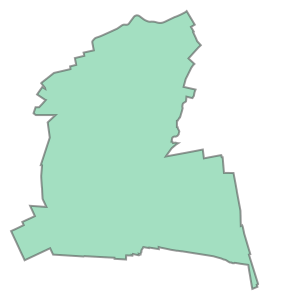

In [3]:
gemeenteGDF.iloc[1].geometry # an example of a single polygon

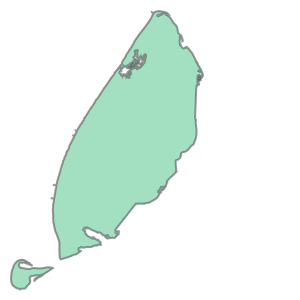

In [4]:
gemeenteGDF.iloc[3].geometry # a more complicated shape - MultiPolygon, with a hole in one of the parts

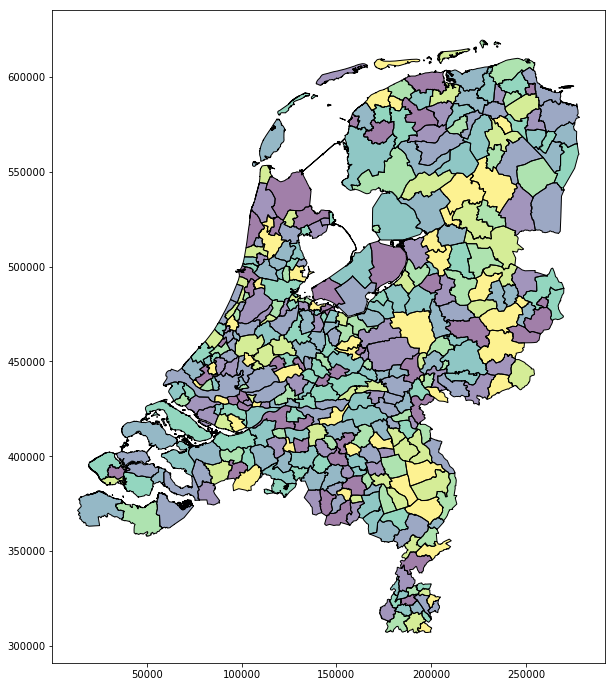

In [5]:
gemeenteGDF.plot() # geopandas knows how to plot itself

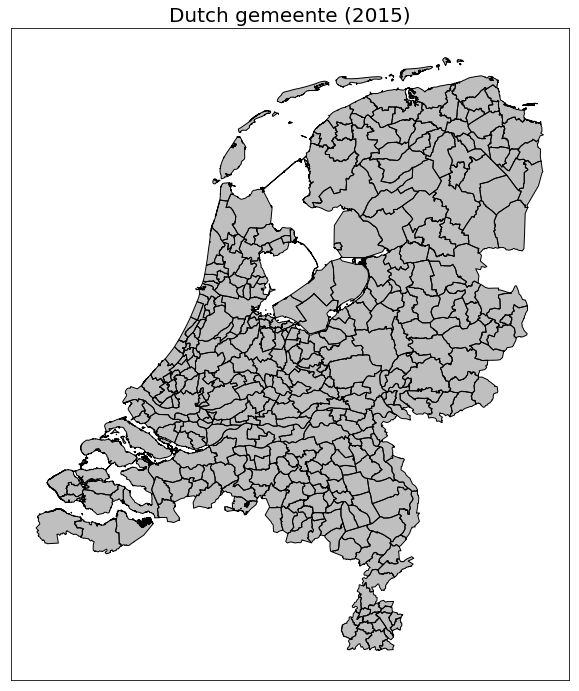

In [6]:
# the usual matplotlib commands work as expected

fig, ax = plt.subplots(figsize=(10,12))

gemeenteGDF.plot(ax=ax, color='grey')

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_title('Dutch gemeente (2015)', fontsize=20)

# Choropleth maps - coloring regions by a property

In [7]:
import pandas as pd

# load Alzheimer's data into a DataFrame

alzDF = pd.read_csv('alz_data_for_demo.csv', index_col=0)

alzDF.sample(5)

,Gemeente,2015,2020,2025,2030,2035,2040,Provincie,Population,Births,...,Alzheimer prevalence,Region Code,0-19,20-29,30-39,40-49,50-64,65-79,80+,Over 65 %
310,Dongen,400,460,550,660,780,880,Noord-Brabant,25395,222,...,1.575113,GM0766,5705.0,2645.0,2747.0,3826.0,5581.0,3803.0,1088.0,19.3
192,Waddinxveen,420,490,560,670,780,870,Zuid-Holland,25657,273,...,1.636980,GM0627,6030.0,2975.0,2784.0,3526.0,5477.0,3656.0,1209.0,19.0
3,De Marne,190,210,240,280,320,350,Groningen,10157,73,...,1.870631,GM1663,2145.0,956.0,967.0,1439.0,2403.0,1745.0,502.0,22.1
168,Leiden,1500,1600,1800,2200,2600,2800,Zuid-Holland,121562,1209,...,1.233938,GM0546,24222.0,26002.0,16676.0,15899.0,21870.0,12734.0,4159.0,13.9
222,Vianen,300,370,460,570,680,780,Utrecht,19632,185,...,1.528117,GM0620,4656.0,2058.0,2124.0,3032.0,4079.0,2868.0,815.0,18.8


In [8]:
alzGDF = pd.merge(gemeenteGDF, alzDF, left_on='GMCODE', right_on='Region Code') # usual pandas merge

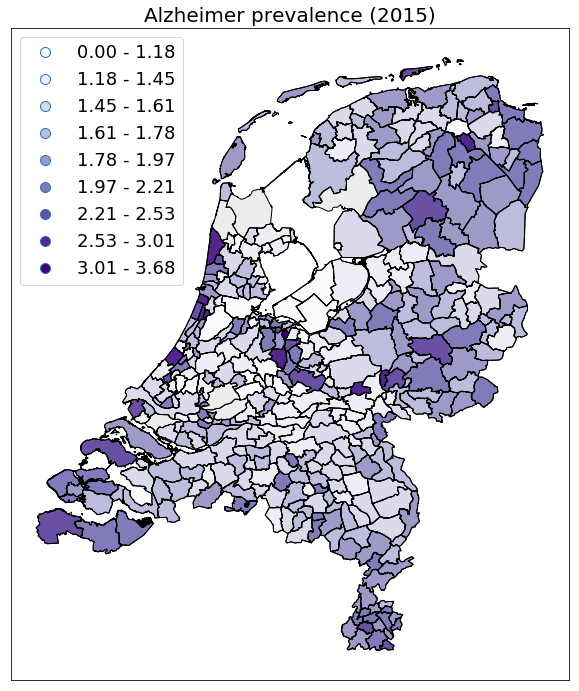

In [9]:
fig,ax = plt.subplots()

gemeenteGDF.plot(ax=ax, color='#dddddd', alpha=0.5) # grey base, shows regions with missing data

###########################

# overlay choropleth map
# only pick gemeente with known prevalence
alzGDF[~alzGDF['Alzheimer prevalence'].isnull()].plot(ax=ax, column='Alzheimer prevalence', cmap='Purples', 
                                                      scheme='Fisher_Jenks', k=9, legend=True, alpha=1.)

###########################

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_title('Alzheimer prevalence (2015)', fontsize=20)

# Spatial joins

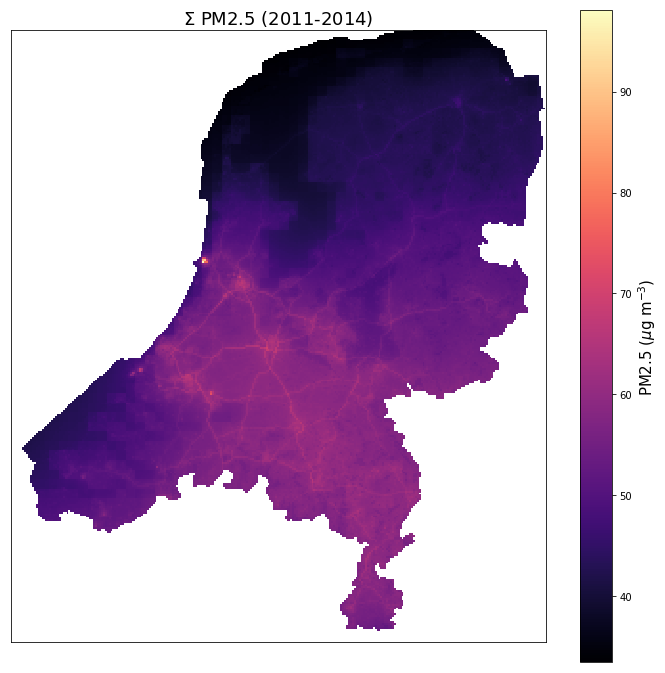

In [10]:
import numpy as np

pm25map = None

# load and sum the PM2.5 data for individual years skipping the header
for yr in range(2011,2015):
    if pm25map is None:
        pm25map = np.loadtxt('/home/ondrej/experiment/air_quality/conc_pm25_{0}.asc'.format(yr), skiprows=6)
    else:
        pm25map = pm25map + np.loadtxt('/home/ondrej/experiment/air_quality/conc_pm25_{0}.asc'.format(yr), skiprows=6)

# the header specifies that NaNs are -999
pm25map[pm25map < 0] = np.nan

#plot data
fig,ax = plt.subplots(figsize=(12,12))

im = ax.imshow(pm25map, cmap='magma')
cbar = plt.colorbar(im)
cbar.ax.set_ylabel(r'PM2.5 ($\mu$g m$^{-3}$)', fontsize=15)

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title(r'$\Sigma$ PM2.5 (2011-2014)', fontsize=18)

In [11]:
from shapely.geometry import Point

ll = [0,300000] #lower left corner in EPSG:28992 <- specified in README

# x and y distances (in meters) of the individual cells from the lower left corner
# good that EPSG:28992 is in meters
x,y = np.meshgrid(np.arange(pm25map.shape[1]),np.arange(pm25map.shape[0]-1,-1,-1))
x *= 1000
y *= 1000

# each point of the grid starts at the same location (lower left corner)
lonLL = ll[0]*np.ones(pm25map.shape)
latLL = ll[1]*np.ones(pm25map.shape)

# assign coordinates to each grid cell
lon, lat = lonLL+x,latLL+y

# defining shapely points to be able to to geospatial operations
coords = [Point(x,y) for x,y in zip(lon.reshape(lon.size),lat.reshape(lat.size))]
values = pm25map.reshape(pm25map.size)

#define GeoDataFrame
pmGDF = gpd.GeoDataFrame({'pm25': values, 'geometry': coords}).dropna()

#assign its coordinate system
pmGDF.crs = gemeenteGDF.crs

pmGDF.sample(5)

,geometry,pm25
12813,POINT (213000 574000),44.160
14684,POINT (124000 567000),38.739
17300,POINT (220000 558000),42.090
64411,POINT (11000 389000),43.810
47821,POINT (221000 449000),54.350


In [12]:
# spatial joint itself - 'right' means the final geometry will come from the right GeoDataFrame
# i.e. each point of the 1x1km grid will end up with the ful info of the gemeente it belongs to
pm_joinedGDF = gpd.sjoin(pmGDF, gemeenteGDF, how='right', op='within')

# calculate mean PM2.5 for each gemeente
pm_joinedGDF = pm_joinedGDF.groupby('GMCODE').mean()['pm25'].to_frame()

pm_joinedGDF.sample(5)

,pm25
GMCODE,
GM1680,42.797908
GM0717,47.217910
GM1734,59.480357
GM0479,55.075595
GM0718,50.170000


In [13]:
# put the mean PM2.5 into the original GeoDataFrame
gemGDF = pd.merge(gemeenteGDF,pm_joinedGDF, left_on='GMCODE', right_index=True)

gemGDF.sample(5)

,GMCODE,GMNAAM,OBJECTID,OBJECTID_1,OMSCHRIJVI,PROVCODE,PROVNAAM,SHAPE_LENG,TDN_CODE,geometry,pm25
377,GM0981,Vaals,378,378,Vaals,30223,Limburg,27252.612204,9813,"POLYGON ((193713.9199798528 307595.4544940079,...",54.836667
366,GM0820,"Nuenen, Gerwen en Nederwetten",328,328,Nuenen c.a.,30213,Noord-Brabant,35032.075633,8203,"POLYGON ((168176.5117022386 390066.8059517111,...",59.808857
335,GM0677,Hulst,343,343,Hulst,30203,Zeeland,265842.138695,6773,(POLYGON ((58020.33175469516 380563.5820782254...,52.312271
259,GM0815,Mill en Sint Hubert,281,281,Mill en Sint Hubert,30213,Noord-Brabant,35132.014498,8153,"POLYGON ((183000.1851097742 414721.3706654649,...",58.293208
198,GM0202,Arnhem,193,193,Arnhem,30153,Gelderland,60206.514746,2023,"POLYGON ((193331.780089931 454529.5306091915, ...",57.630100


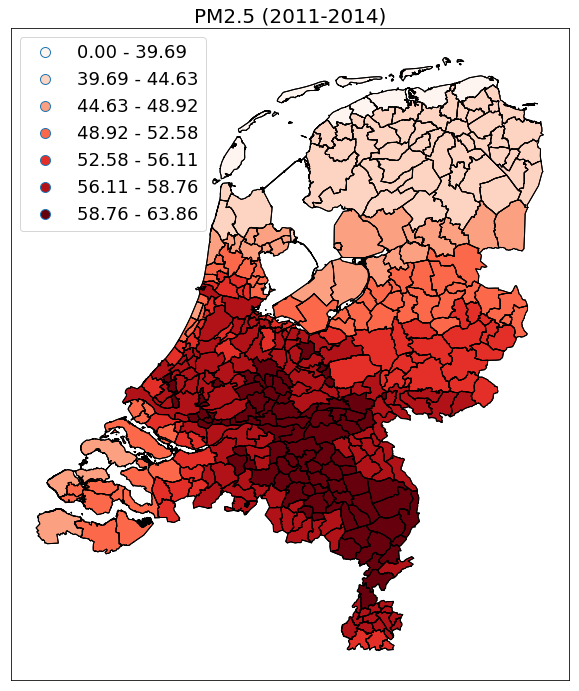

In [14]:
fig, ax = plt.subplots(figsize=(10,12))

gemGDF.plot(ax=ax, color='#dddddd', alpha=0.5)
gemGDF[~gemGDF['pm25'].isnull()].plot(ax=ax, column='pm25', cmap='Reds', scheme='Fisher_Jenks', k=7,
                                     legend=True, alpha=1.0)

ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticklabels([])
ax.set_yticks([])

ax.set_title('PM2.5 (2011-2014)', fontsize=20)

# 2 Interactive maps

## 2.1 mplleaflet

Exports matplotlib into leaflet, a philosophy similar to mpld3. Quite simple, but unable to, say, plot legend (will fail on that).

In [95]:
import mplleaflet

# this we did above
fig, ax = plt.subplots(figsize=(10,12))

gemGDF.plot(ax=ax, color='#dddddd', alpha=0.9)
gemGDF[~gemGDF['pm25'].isnull()].plot(ax=ax, column='pm25', cmap='Reds', scheme='Fisher_Jenks', k=9, alpha=1.)

# this is new - don't forget the appropriate CRS; you can also specify the path of the resulting file
mplleaflet.show(crs=gemGDF.crs, path='mplleaflet_AQ_NL.html')

## 2.2 folium

Also allows for interactive maps. With respect to ```mplleaflet``` allows more flexibility, but requires a tiny bit more preprocessing.

In [ ]:
gem4326GDF['geometry'] = gem4326GDF['geometry'].apply(lambda x: x.buffer(0))

In [ ]:
import folium

gem4326GDF = gemGDF.to_crs(epsg='4326') # transform to WGS84
gem4326
jsontxt = gem4326GDF.to_json() # transform dataframe into JSON

# define a map instance with initial center and zoom
m = folium.Map(location=[52.0,5.5], zoom_start=7, control_scale=True)

m.choropleth(geo_str=jsontxt, data=gem4326GDF, columns=['GMCODE','pm25'], key_on="properties.GMCODE",
                   fill_color='YlOrRd', fill_opacity=0.5, line_opacity=0.9, line_color='black', line_weight=0.4,
             legend_name='PM2.5 in Netherlands', )

# alternatively, just call m to display in notebook
m.save(outfile='folium_AQ_NL_simple.html')

```Folium``` also allows for popups that appear when an object with a popup bound to it is clicked. Popups can contain a lot of different things (as shown [here](http://nbviewer.jupyter.org/github/bibmartin/folium/blob/issue288/examples/Popups.ipynb)). Below, we put the PM2.5 value into a popup that is tied to a marker sitting in the center of each gemeente. This is simple, but also

* impractical, since to get the info you have to click the small marker (that can also lie outside the gemeente for a particularly weird shape)
* quite ugly

In [ ]:
m = folium.Map(location=[52.0,5.5], zoom_start=7, control_scale=True)

# marker cluster merges markers that are close togerther under current zoom
marker_cluster = folium.MarkerCluster().add_to(m)

m.choropleth(geo_str=jsontxt, data=gem4326GDF, columns=['GMCODE','pm25'], key_on="properties.GMCODE",
                   fill_color='YlOrRd', fill_opacity=0.5, line_opacity=0.9, line_color='black', line_weight=0.4,
             legend_name='PM2.5 in Netherlands', )

for idx, row in gem4326GDF.iterrows():
    # Get lat and lon of points
    lon = row['geometry'].centroid.x
    lat = row['geometry'].centroid.y

    pmValue = row['pm25']
    # Add marker to the map and tie a popup to it - careful about the order of lat and lon!
    folium.RegularPolygonMarker(location=[lat, lon], popup='PM2.5: {0:.2f}'.format(pmValue),
                               fill_color='#2b8cbe', number_of_sides=10, radius=3).add_to(marker_cluster)

m.save(outfile='folium_AQ_NL_ugly_popups.html')

With a bit more work, however, assigning popups to the shapes themselves is possible (i.e., clicking anywhere within a gemeente shows a popup). ```style_function``` has to be defined by the programmer, however.

In [ ]:
m = folium.Map(location=[52.0,5.5], zoom_start=7, control_scale=True)

style_function = lambda feature: {
    'fillColor': 'grey', 
    'color': 'white',
    'weight': 1,
    'opacity': 0.8,
    'fillOpacity': 0.8
}

for gemeente,row in gem4326GDF.iterrows():
    poly = folium.GeoJson(dict(row), style_function = style_function)
    poly.add_children(folium.Popup('{0}: {1:.2f}'.format(row['GMNAAM'],row['pm25'])))
    poly.add_to(m)

m.save(outfile='folium_AQ_NL.html')

## 2.3 bokeh

Another package that produces good-loking and interacive visualizations. Improving upon ```folium```, it contains ```HoverTool```s, that show information when the mouse is hovered over an area. The downsides are, that plotting requires a bit of preprocessing, as ```bokeh``` doesn't handle shapes directly and we need to extract the lists of polygon coordinates. Furthermore, it can't handle polygons with holes.

In [ ]:
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, HoverTool, FixedTicker
from bokeh.palettes import RdYlBu11 as palette
from bokeh.plotting import figure
from bokeh.io import show, output_notebook, output_file, save

# allows for output into notebook
output_notebook()


In [ ]:
# coordinate transformation (in case we didn't do it in the folium section)
gem4326GDF = gemGDF.to_crs(epsg='4326')

gemGDF.geometry.apply(lambda x: x.geom_type).unique()

Ther are both polygons and multipolygons in our data, that need to be treated separately.

In [ ]:
# lists of lists of coordinates
xs = []
ys = []

#lists for additional info to be shown by the hovertool
names = []
pm25s = []

for ind,row in gem4326GDF.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        geomList = [row['geometry']]
    else:
        geomList = row['geometry']
    for poly in geomList:
        # extract the coordinates of the exterior of the polygon (or individual polygons within a multipolygon)
        # holes are ignored here
        xs.append(list(poly.exterior.coords.xy[0]))
        ys.append(list(poly.exterior.coords.xy[1]))
        names.append(row['GMNAAM'])
        pm25s.append(row['pm25'])

sourceData = ColumnDataSource(data=pd.DataFrame({'x': xs, 'y': ys, 'name': names, 'pm25': pm25s}))            

In [ ]:
color_mapper = LinearColorMapper(palette=palette)

# tools to be available in the final visualization
TOOLS = "pan,wheel_zoom,box_zoom,reset,hover,save"

# define the figure
p = figure(title="PM2.5 in Netherlands (2011-2014)", tools=TOOLS,
          x_axis_location=None, y_axis_location=None)

# plot the individual gemeente as patches
p.patches('x', 'y', source=sourceData,
         fill_color={'field': 'pm25', 'transform': color_mapper},
         fill_alpha=1.0, line_color="black", line_width=0.05)

# add colorbar on the left side
color_bar = ColorBar(color_mapper=color_mapper, location=(0,0), title='PM2.5', title_standoff=10,
                     ticker=FixedTicker(ticks=np.linspace(min(pm25s),max(pm25s),8)), label_standoff=12)
p.add_layout(color_bar, 'left')

#define the over tool
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Gemeente", "@name"),
    ("PM2.5 ug/m3", "@pm25"),
]

# h = show(p) #<- this to show in the notebook
h = save(p,'bokeh_AQ_NL.html') #<- this to save to a file